# Análisis VBox KDE

Importación de librerías:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import numpy as np
import warnings
from ipywidgets import interact, FloatRangeSlider
from matplotlib.widgets import RectangleSelector
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display
import folium
import numpy as np
from folium.plugins import HeatMap
import branca.colormap as cm
import pandas as pd

Cargar datos necesarios:

In [2]:
file_path = "20240808. Plantilla Data TK419 8-ago-24.csv"
df = pd.read_csv(file_path, encoding="latin1")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158410 entries, 0 to 158409
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   UTC time                         158410 non-null  float64
 1   Satellites                       158410 non-null  int64  
 2   Speed (km/h)                     158410 non-null  float64
 3   Heading (Degrees)                158410 non-null  float64
 4   Latitude                         158410 non-null  object 
 5   Longitude                        158410 non-null  object 
 6   BrakeTrigger                     158410 non-null  int64  
 7   Dgps                             158410 non-null  int64  
 8   Wav file                         158410 non-null  int64  
 9   Dual antenna                     158410 non-null  int64  
 10  Height (m)                       158410 non-null  float64
 11  Vertical velocity (km/h)         158410 non-null  float64
 12  Lo

,UTC time,Satellites,Speed (km/h),Heading (Degrees),Latitude,Longitude,BrakeTrigger,Dgps,Wav file,Dual antenna,...,Day,Relative height (m),Radius of turn (m),MovingAvgFront,MovingAvgRear,TxPhF,TxPhR,VehicleWeight (tonnes),Latitude.1,Longitude.1
0,171136.4,4,3.93,290.1,18°56.877760 N,70°10.315430 W,0,0,0,0,...,NaN,-31833.80,2.68,0.000000,0.000000,56,56,140,18.947963,-70.171924
1,171137.4,4,0.00,256.6,18°56.880640 N,70°10.318830 W,0,0,0,0,...,NaN,-31833.40,0.00,0.000000,0.000000,56,56,140,18.948011,-70.171981
2,171138.4,4,1.82,302.9,18°56.880880 N,70°10.319190 W,0,0,0,0,...,NaN,-31833.52,1.52,0.000000,0.000000,56,56,140,18.948015,-70.171987
3,171139.4,4,2.08,319.2,18°56.880310 N,70°10.318610 W,0,0,0,0,...,NaN,-31834.05,3.41,0.022259,0.022596,56,56,140,18.948005,-70.171977
4,171140.4,4,2.98,319.0,18°56.878910 N,70°10.317810 W,0,0,0,0,...,NaN,-31834.60,2.28,0.000000,0.000000,56,56,140,18.947982,-70.171964


Conversión de variables:

In [3]:
# Convertir UTC time a timestamp
df["UTC time"] = pd.to_numeric(df["UTC time"], errors="coerce")
df["Time (seconds)"] = df["UTC time"] % 100
df["Time (minutes)"] = (df["UTC time"] // 100) % 100
df["Time (hours)"] = df["UTC time"] // 10000
df["Timestamp"] = pd.to_datetime(df["Time (hours)"].astype(int).astype(str) + ":" +
                                 df["Time (minutes)"].astype(int).astype(str) + ":" +
                                 df["Time (seconds)"].astype(int).astype(str), 
                                 format="%H:%M:%S", errors="coerce")
df.head()

,UTC time,Satellites,Speed (km/h),Heading (Degrees),Latitude,Longitude,BrakeTrigger,Dgps,Wav file,Dual antenna,...,MovingAvgRear,TxPhF,TxPhR,VehicleWeight (tonnes),Latitude.1,Longitude.1,Time (seconds),Time (minutes),Time (hours),Timestamp
0,171136.4,4,3.93,290.1,18°56.877760 N,70°10.315430 W,0,0,0,0,...,0.000000,56,56,140,18.947963,-70.171924,36.4,11.0,17.0,1900-01-01 17:11:36
1,171137.4,4,0.00,256.6,18°56.880640 N,70°10.318830 W,0,0,0,0,...,0.000000,56,56,140,18.948011,-70.171981,37.4,11.0,17.0,1900-01-01 17:11:37
2,171138.4,4,1.82,302.9,18°56.880880 N,70°10.319190 W,0,0,0,0,...,0.000000,56,56,140,18.948015,-70.171987,38.4,11.0,17.0,1900-01-01 17:11:38
3,171139.4,4,2.08,319.2,18°56.880310 N,70°10.318610 W,0,0,0,0,...,0.022596,56,56,140,18.948005,-70.171977,39.4,11.0,17.0,1900-01-01 17:11:39
4,171140.4,4,2.98,319.0,18°56.878910 N,70°10.317810 W,0,0,0,0,...,0.000000,56,56,140,18.947982,-70.171964,40.4,11.0,17.0,1900-01-01 17:11:40


Análisis estadístico de variables:

In [4]:
df.describe()

,UTC time,Satellites,Speed (km/h),Heading (Degrees),BrakeTrigger,Dgps,Wav file,Dual antenna,Height (m),Vertical velocity (km/h),...,MovingAvgRear,TxPhF,TxPhR,VehicleWeight (tonnes),Latitude.1,Longitude.1,Time (seconds),Time (minutes),Time (hours),Timestamp
count,158410.000000,158410.000000,158410.000000,158410.000000,158410.0,158410.0,158410.0,158410.0,158410.000000,158410.000000,...,158410.000000,158410.000000,158410.000000,158410.0,158410.000000,158410.000000,158410.000000,158410.000000,158410.000000,158410
mean,115084.056486,6.771208,9.861244,184.400155,0.0,0.0,0.0,0.0,175.931076,-0.043856,...,8.695991,393.171965,342.911817,140.0,18.937447,-70.178886,29.909020,29.497349,11.210441,1900-01-01 11:42:36.931758848
min,0.900000,4.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-144.820000,-29.050000,...,0.000000,0.000000,0.000000,140.0,18.906577,-70.195912,0.000000,0.000000,0.000000,1900-01-01 00:00:00
25%,53014.950000,6.000000,0.000000,93.900000,0.0,0.0,0.0,0.0,114.880000,-0.790000,...,0.000000,158.000000,154.000000,140.0,18.933342,-70.182980,15.000000,14.000000,5.000000,1900-01-01 05:30:14.249999872
50%,110020.350000,7.000000,1.840000,182.100000,0.0,0.0,0.0,0.0,159.760000,0.090000,...,0.000000,302.000000,293.000000,140.0,18.941344,-70.179028,30.000000,29.000000,11.000000,1900-01-01 11:00:20
75%,182952.400000,7.000000,14.500000,279.700000,0.0,0.0,0.0,0.0,239.250000,0.890000,...,0.000000,612.000000,570.000000,140.0,18.946003,-70.172178,45.000000,45.000000,18.000000,1900-01-01 18:29:52
max,235959.900000,8.000000,171.550000,360.000000,0.0,0.0,0.0,0.0,796.130000,137.740000,...,1008.161302,894.000000,755.000000,140.0,18.957881,-70.165875,59.900000,59.000000,23.000000,1900-01-01 23:59:59
std,71515.939710,0.852974,13.700746,105.169663,0.0,0.0,0.0,0.0,78.492673,2.548471,...,74.697261,280.837637,238.835602,0.0,0.011920,0.007603,17.319471,17.319458,7.148891,NaN


## Estableciendo criticidades
Acá vamos a poner las criticidades. Probamos:

In [5]:
#-----------------------------------------------------------
#---------- Identificación de eventos críticos -------------
#-----------------------------------------------------------

# df["Sharp Turn"] = df["Radius of turn (m)"].apply(lambda x: x < 5)  # Giro pronunciado menor a 5 m
df["High Speed"] = df["Speed (km/h)"].apply(lambda x: x > 50)  # Velocidad superior a 50 km/h
# df["Critical Event"] = df[["Sharp Turn", "High Speed"]].any(axis=1)
df["Critical Event"] = df[[ "High Speed"]].any(axis=1)


### Revisión de puntos críticos:

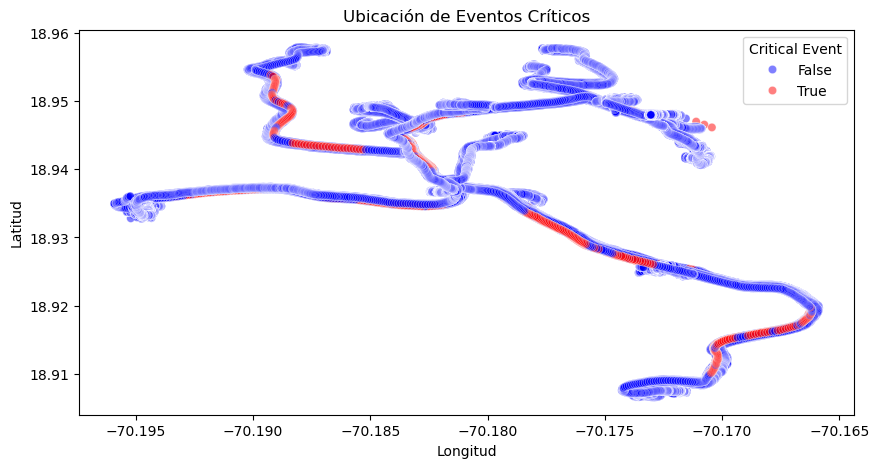

In [6]:
# Visualización de eventos críticos
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Longitude.1"], y=df["Latitude.1"], hue=df["Critical Event"], palette={True: "red", False: "blue"}, alpha=0.5)
plt.title("Ubicación de Eventos Críticos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


### Mapa de calor de puntos criticos.

In [7]:
# Asegurar que las coordenadas y velocidades sean numéricas
df["Latitude.1"] = pd.to_numeric(df["Latitude.1"], errors="coerce")
df["Longitude.1"] = pd.to_numeric(df["Longitude.1"], errors="coerce")
df["Speed (km/h)"] = pd.to_numeric(df["Speed (km/h)"], errors="coerce")

# Filtrar solo los datos con velocidades mayores a 50 km/h
df_filtrado = df[df["Speed (km/h)"] > 50]

# Crear el mapa centrado en la media de las coordenadas filtradas
mapa = folium.Map(
    location=[df_filtrado["Latitude.1"].mean(), df_filtrado["Longitude.1"].mean()], 
    zoom_start=12, 
    tiles="Esri WorldImagery"  # Opción de relieve
)

# Crear la capa de calor con la velocidad como peso
heat_data = list(zip(df_filtrado["Latitude.1"], df_filtrado["Longitude.1"], df_filtrado["Speed (km/h)"]))
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=10, blur=15).add_to(mapa)

# Crear la escala de colores para la velocidad
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=50,  # El mínimo ahora es 50 km/h
    vmax=df["Speed (km/h)"].max(),
    caption="Velocidad (km/h)"
)

# Agregar la barra de colores al mapa
colormap.add_to(mapa)

# Mostrar el mapa interactivo
mapa


### Distribuciones de datos

C:\Users\jacosta\AppData\Local\Temp\ipykernel_59556\4160082726.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Critical Event"], palette=["blue", "red"])


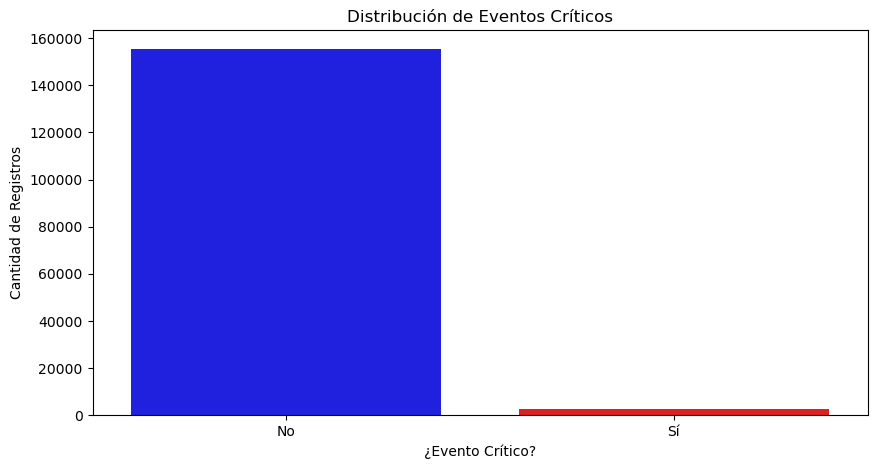

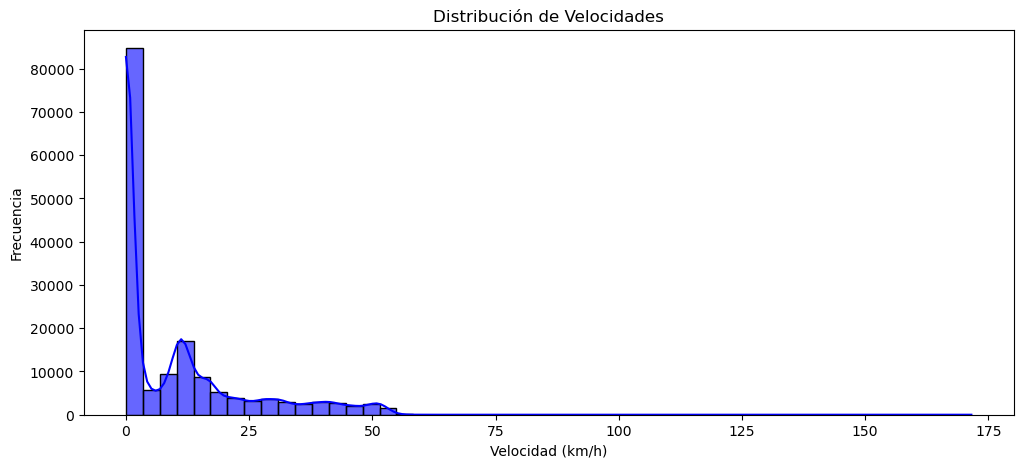

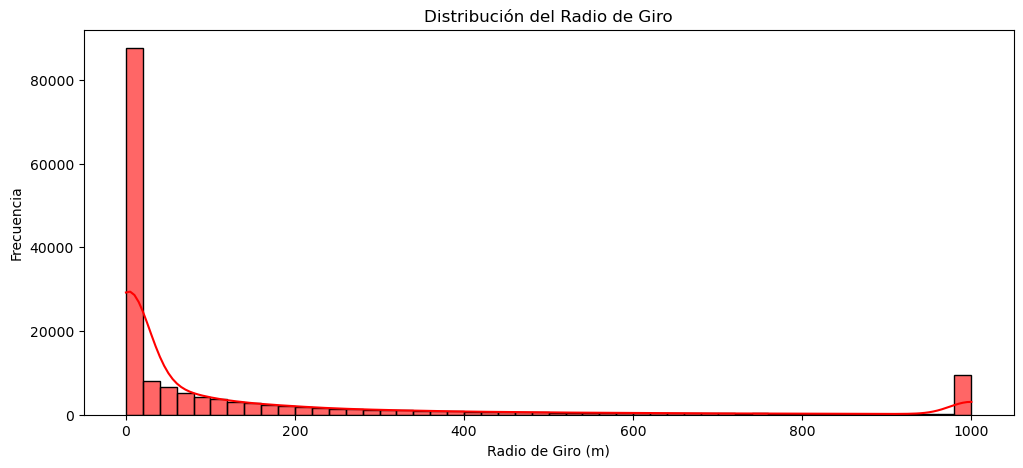

In [8]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 5))

# Gráfico de barras de eventos críticos vs. no críticos
sns.countplot(x=df["Critical Event"], palette=["blue", "red"])
plt.title("Distribución de Eventos Críticos")
plt.xlabel("¿Evento Crítico?")
plt.ylabel("Cantidad de Registros")
plt.xticks(ticks=[0, 1], labels=["No", "Sí"])
plt.show()

# Análisis por velocidad y radio de giro
plt.figure(figsize=(12, 5))

# Distribución de velocidad
sns.histplot(df["Speed (km/h)"], bins=50, kde=True, color="blue", alpha=0.6)
plt.title("Distribución de Velocidades")
plt.xlabel("Velocidad (km/h)")
plt.ylabel("Frecuencia")
plt.show()

# Distribución del radio de giro
plt.figure(figsize=(12, 5))
sns.histplot(df["Radius of turn (m)"], bins=50, kde=True, color="red", alpha=0.6)
plt.title("Distribución del Radio de Giro")
plt.xlabel("Radio de Giro (m)")
plt.ylabel("Frecuencia")
plt.show()


## Análisis Espacial: 

### Análisis de densidad Bivariada: 



<Figure size 1000x800 with 0 Axes>

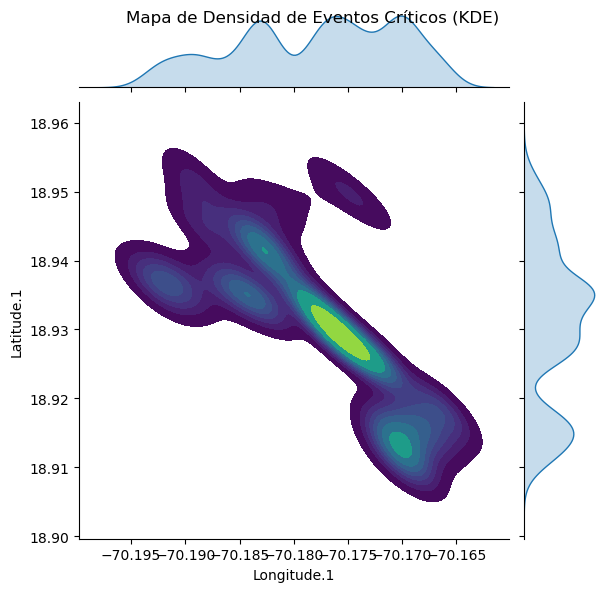

In [9]:
#solo puntos criticos
df_critical = df[df["Critical Event"]]

#jointplot con KDE densidad de kernel
plt.figure(figsize=(10, 8))
sns.jointplot(data=df_critical, x="Longitude.1", y="Latitude.1", kind="kde", fill=True, cmap="viridis")

plt.suptitle("Mapa de Densidad de Eventos Críticos (KDE)")
plt.show()

### Análisis de clustering (Zonas con Altas densidades):

Visualizacion de clustering y puntos criticos

In [10]:
import folium
import geopandas as gpd
import numpy as np
from folium.plugins import HeatMap
from scipy.stats import gaussian_kde
import branca.colormap as cm

# Convertir DataFrame a GeoDataFrame en EPSG:4326
puntos = gpd.GeoDataFrame(df, 
                          geometry=gpd.points_from_xy(df["Longitude.1"], df["Latitude.1"]), 
                          crs="epsg:4326")

# Filtrar eventos críticos
puntos_critical = puntos[puntos["Critical Event"] == True]

# Extraer coordenadas
x = puntos_critical.geometry.x
y = puntos_critical.geometry.y

# KDE sobre coordenadas
kde = gaussian_kde(np.vstack([x, y]))

# Malla para KDE en coordenadas geográficas
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
yy, xx = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.reshape(kde(positions).T, xx.shape)

# Normalización de densidad
density_normalized = (density - np.min(density)) / np.ptp(density)

# Datos para HeatMap en formato Folium
heat_data = np.array([
    [yy.ravel()[i], xx.ravel()[i], density_normalized.ravel()[i]] 
    for i in range(len(xx.ravel()))
])

# Crear el mapa con relieve
mapa = folium.Map(
    location=[y.mean(), x.mean()], 
    zoom_start=12, 
    tiles="Esri.WorldImagery"
)

# Capa de calor KDE
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Barra de colores ajustada
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=0, 
    vmax=1,
    caption="Densidad de Eventos Críticos"
)

colormap.add_to(mapa)

# Mostrar mapa interactivo
mapa


In [11]:
import h3
import geopandas as gpd
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
from scipy.stats import gaussian_kde

# Configuración del nivel de resolución de H3
H3_RESOLUTION = 12  # Ajusta según el nivel de detalle necesario

# Convertir DataFrame a GeoDataFrame
puntos = gpd.GeoDataFrame(df, 
                          geometry=gpd.points_from_xy(df["Longitude.1"], df["Latitude.1"]), 
                          crs="epsg:4326")

# Filtrar eventos críticos
puntos_critical = puntos[puntos["Critical Event"] == True]

# ⚠️ Verificar si hay eventos críticos
if puntos_critical.empty:
    print("⚠️ No hay eventos críticos en los datos.")
    raise ValueError("Revisa el filtro de 'Critical Event'.")

# Obtener coordenadas
x = puntos_critical.geometry.x
y = puntos_critical.geometry.y

# Aplicar Kernel Density Estimation (KDE)
kde = gaussian_kde(np.vstack([x, y]))

# Generar índices H3 para el área de los datos
h3_indices = set()
for lon, lat in zip(x, y):
    h3_indices.add(h3.latlng_to_cell(lat, lon, H3_RESOLUTION))

# Obtener centroides de cada hexágono
h3_centroids = {h: h3.cell_to_latlng(h) for h in h3_indices}

# Convertir a DataFrame
df_h3 = pd.DataFrame(h3_centroids).T.reset_index()
df_h3.columns = ["h3_index", "lat", "lon"]

# Evaluar KDE en los centroides de H3
kde_values = kde(np.vstack([df_h3["lon"], df_h3["lat"]]))

# Normalizar KDE para representar correctamente la densidad
df_h3["density"] = (kde_values - np.min(kde_values)) / (np.ptp(kde_values) + 1e-6)

# ⚠️ Verificar valores de densidad
print("Density Min:", df_h3["density"].min(), "Max:", df_h3["density"].max())

# Crear mapa centrado en los hexágonos
mapa = folium.Map(location=[df_h3["lat"].mean(), df_h3["lon"].mean()], zoom_start=12, tiles="Esri.WorldImagery")

# Ajustar colormap correctamente
colormap = cm.LinearColormap(
    ["blue", "green", "yellow", "red"],
    vmin=df_h3["density"].min(),
    vmax=df_h3["density"].max(),
    caption="Densidad de Eventos Críticos"
)
colormap.add_to(mapa)

# Agregar hexágonos H3 al mapa
for _, row in df_h3.iterrows():
    hex_boundary = [(lat, lon) for lon, lat in h3.cell_to_boundary(row["h3_index"])]
    
    folium.Polygon(
        locations=hex_boundary,
        color="black",  # Contorno negro para hacer visible el hexágono
        weight=1,
        fill=True,
        fill_color=colormap(row["density"]),
        fill_opacity=1.0,
    ).add_to(mapa)

# Crear la lista de puntos para el HeatMap con la densidad como peso
heat_data = [[row["lat"], row["lon"], row["density"]] for _, row in df_h3.iterrows()]

# Agregar la capa de calor al mapa
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Encontrar el punto con la densidad máxima
punto_max = df_h3.loc[df_h3["density"].idxmax()]

# Agregar un marcador en el punto más crítico
folium.Marker(
    location=[punto_max["lat"], punto_max["lon"]],
    popup="📍 Punto más crítico del mapa",
    icon=folium.Icon(color="red", icon="exclamation-circle", prefix="fa")
).add_to(mapa)

# Mostrar el mapa interactivo
from IPython.display import display
display(mapa)


Density Min: 0.0 Max: 0.9999999998838237


# PRUEBA DENSIDADES CON REFE EVALUADA:

## Criticidad Velocidades 

In [4]:
import pandas as pd
import numpy as np
import h3
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

# Cargar datos exportados por tu sistema
df = pd.read_csv("datavvh_simplificada (1).csv")

# Verificar columnas necesarias
df_h3 = df[["h3_r12", "latitudet", "longitudet", "kde_velocidad"]].dropna().drop_duplicates(subset=["h3_r12"])
df_h3 = df_h3.rename(columns={"latitudet": "lat", "longitudet": "lon", "kde_velocidad": "density"})

# Crear el mapa
mapa = folium.Map(location=[df_h3["lat"].mean(), df_h3["lon"].mean()], zoom_start=13, tiles="Esri.WorldImagery")

# Crear escala de colores
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=0, vmax=1, caption="Densidad KDE - Velocidad")
colormap.add_to(mapa)

# Dibujar hexágonos H3
for _, row in df_h3.iterrows():
    try:
        hex_boundary = [(lat, lon) for lon, lat in h3.cell_to_boundary(row["h3_r12"])]
        folium.Polygon(
            locations=hex_boundary,
            color="black",
            weight=1,
            fill=True,
            fill_color=colormap(row["density"]),
            fill_opacity=1.0,
        ).add_to(mapa)
    except Exception:
        continue

# Heatmap sobre centros
heat_data = [[row["lat"], row["lon"], row["density"]] for _, row in df_h3.iterrows()]
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Marcar el punto más crítico
punto_max = df_h3.loc[df_h3["density"].idxmax()]
folium.Marker(
    location=[punto_max["lat"], punto_max["lon"]],
    popup="📍 Punto más crítico del mapa",
    icon=folium.Icon(color="red", icon="exclamation-circle", prefix="fa")
).add_to(mapa)

# Guardar o mostrar
mapa.save("mapa_criticidad_velocidad.html")


## Criticidad AC Laterales

In [3]:
import pandas as pd
import numpy as np
import h3
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

# Cargar datos exportados por tu sistema
df = pd.read_csv("datavvh_simplificada (1).csv")

# Verificar columnas necesarias
df_h3 = df[["h3_r12", "latitudet", "longitudet", "kde_ac_laterales"]].dropna().drop_duplicates(subset=["h3_r12"])
df_h3 = df_h3.rename(columns={"latitudet": "lat", "longitudet": "lon", "kde_ac_laterales": "density"})

# Crear el mapa
mapa = folium.Map(location=[df_h3["lat"].mean(), df_h3["lon"].mean()], zoom_start=13, tiles="Esri.WorldImagery")

# Crear escala de colores
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=0, vmax=1, caption="Densidad KDE - ac laterales")
colormap.add_to(mapa)

# Dibujar hexágonos H3
for _, row in df_h3.iterrows():
    try:
        hex_boundary = [(lat, lon) for lon, lat in h3.cell_to_boundary(row["h3_r12"])]
        folium.Polygon(
            locations=hex_boundary,
            color="black",
            weight=1,
            fill=True,
            fill_color=colormap(row["density"]),
            fill_opacity=1.0,
        ).add_to(mapa)
    except Exception:
        continue

# Heatmap sobre centros
heat_data = [[row["lat"], row["lon"], row["density"]] for _, row in df_h3.iterrows()]
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Marcar el punto más crítico
punto_max = df_h3.loc[df_h3["density"].idxmax()]
folium.Marker(
    location=[punto_max["lat"], punto_max["lon"]],
    popup="📍 Punto más crítico del mapa",
    icon=folium.Icon(color="red", icon="exclamation-circle", prefix="fa")
).add_to(mapa)

# Guardar o mostrar
mapa.save("mapa_criticidad_ac_laterales.html")


## Criticidad AC Longitudinales

In [5]:
import pandas as pd
import numpy as np
import h3
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

# Cargar datos exportados por tu sistema
df = pd.read_csv("datavvh_simplificada (1).csv")

# Verificar columnas necesarias
df_h3 = df[["h3_r12", "latitudet", "longitudet", "kde_ac_longitudinales"]].dropna().drop_duplicates(subset=["h3_r12"])
df_h3 = df_h3.rename(columns={"latitudet": "lat", "longitudet": "lon", "kde_ac_longitudinales": "density"})

# Crear el mapa
mapa = folium.Map(location=[df_h3["lat"].mean(), df_h3["lon"].mean()], zoom_start=13, tiles="Esri.WorldImagery")

# Crear escala de colores
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=0, vmax=1, caption="Densidad KDE - ac longitudinales")
colormap.add_to(mapa)

# Dibujar hexágonos H3
for _, row in df_h3.iterrows():
    try:
        hex_boundary = [(lat, lon) for lon, lat in h3.cell_to_boundary(row["h3_r12"])]
        folium.Polygon(
            locations=hex_boundary,
            color="black",
            weight=1,
            fill=True,
            fill_color=colormap(row["density"]),
            fill_opacity=1.0,
        ).add_to(mapa)
    except Exception:
        continue

# Heatmap sobre centros
heat_data = [[row["lat"], row["lon"], row["density"]] for _, row in df_h3.iterrows()]
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Marcar el punto más crítico
punto_max = df_h3.loc[df_h3["density"].idxmax()]
folium.Marker(
    location=[punto_max["lat"], punto_max["lon"]],
    popup="📍 Punto más crítico del mapa",
    icon=folium.Icon(color="red", icon="exclamation-circle", prefix="fa")
).add_to(mapa)

# Guardar o mostrar
mapa.save("mapa_criticidad_ac_longitudinales.html")


## Criticidad V Verticales:

In [6]:
import pandas as pd
import numpy as np
import h3
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

# Cargar datos exportados por tu sistema
df = pd.read_csv("datavvh_simplificada (1).csv")

# Verificar columnas necesarias
df_h3 = df[["h3_r12", "latitudet", "longitudet", "kde_v_verticales"]].dropna().drop_duplicates(subset=["h3_r12"])
df_h3 = df_h3.rename(columns={"latitudet": "lat", "longitudet": "lon", "kde_v_verticales": "density"})

# Crear el mapa
mapa = folium.Map(location=[df_h3["lat"].mean(), df_h3["lon"].mean()], zoom_start=13, tiles="Esri.WorldImagery")

# Crear escala de colores
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=0, vmax=1, caption="Densidad KDE - v verticales")
colormap.add_to(mapa)

# Dibujar hexágonos H3
for _, row in df_h3.iterrows():
    try:
        hex_boundary = [(lat, lon) for lon, lat in h3.cell_to_boundary(row["h3_r12"])]
        folium.Polygon(
            locations=hex_boundary,
            color="black",
            weight=1,
            fill=True,
            fill_color=colormap(row["density"]),
            fill_opacity=1.0,
        ).add_to(mapa)
    except Exception:
        continue

# Heatmap sobre centros
heat_data = [[row["lat"], row["lon"], row["density"]] for _, row in df_h3.iterrows()]
HeatMap(heat_data, min_opacity=0.2, max_opacity=0.8, radius=15, blur=20).add_to(mapa)

# Marcar el punto más crítico
punto_max = df_h3.loc[df_h3["density"].idxmax()]
folium.Marker(
    location=[punto_max["lat"], punto_max["lon"]],
    popup="📍 Punto más crítico del mapa",
    icon=folium.Icon(color="red", icon="exclamation-circle", prefix="fa")
).add_to(mapa)

# Guardar o mostrar
mapa.save("mapa_criticidad_v_verticales.html")
